# WILLUMP - Tutorial

In this notebook, we'll explain how to use  Willump to improve the performance of feature computation in ML inference applications.

This version of Willump works specifically on binary classification problems. It improves performance via cascades. It tries to predict each data input using an approximate model trained on a handful of high-value, low cost features. For each data input, it returns the approximate prediction if the model's confidence in it is high, but otherwise computes all remaining features and predicts with the original model. For an in-depth demo explaining how Willump works, please see the [explanation notebook](https://github.com/stanford-futuredata/Willump-Simple/blob/master/notebooks/explanation-notebook.ipynb) or [our paper](http://petereliaskraft.net/res/willump.pdf).

We're going to be optimizing a specific application, which predicts whether a content of a text post is toxic. The application was adapted from a entrant in Kaggle's Toxic Comment Classification Challenge.

First, let's import dependencies. Be sure that the printed working directory is the root directory of the Willump-Simple package.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import time
import scipy.sparse
if (os.getcwd().endswith("notebooks")):
    os.chdir("..")
sys.path.insert(0, os.path.abspath("tests/benchmark_scripts"))
print(os.getcwd())

/mnt/c/Users/Peter/Documents/GitHub/Willump-Simple


For Willump to optimize an application with cascades, it must define training, prediction, confidence, and scoring functions.  Each must match an interface.

The training function must take in two arguments.  The first is a vector of binary labels, the second is a list of feature matrices (where each feature matrix has one row per label).  It must return a trained model, which can be of any type.

The prediction function must take in two arguments.  The first is a model of the type returned by the training function.  The second is a list of feature matrices just as in the training function.  It must return a vector of binary predictions, one for each row in the feature matrices.

The arguments of the confidence function are the same as those of the prediction function.  It must return a vector of confidence values, one for each row in the feature matrices, each of which is the probability that the prediction for the row is 1.

The scoring function must take in two arguments.  The first is a vector of binary labels, the second is a vector of binary predictions.  It returns a score of the prediction where higher scores are better.

In [2]:
def toxic_train(y, X_list):
    X = scipy.sparse.hstack([*X_list], format="csr")
    model = LogisticRegression(C=0.1, solver='sag')
    model = model.fit(X, y)
    return model


def toxic_predict(model, X_list):
    X = scipy.sparse.hstack([*X_list], format="csr")
    if X.shape[0] == 0:
        return np.zeros(0, dtype=np.int64)
    else:
        return model.predict(X)


def toxic_confidence(model, X_list):
    X = scipy.sparse.hstack([*X_list], format="csr")
    if X.shape[0] == 0:
        return np.zeros(0, dtype=np.float64)
    else:
        return model.predict_proba(X)[:, 1]


def toxic_score(true_y, pred_y):
    return roc_auc_score(true_y, pred_y)

Before Willump can optimize an application using cascades, it must train the cascades.  We do this at model training time.
We write the model training pipeline in a specific format, like the example below.

The pipeline must be written as a Python function.  Each line of the pipeline must be of the form y = f(x<sub>1</sub>, ..., x<sub>n</sub>) where y and x<sub>1</sub>, ..., x<sub>n</sub> are all Python variables and f is a Python function.  The last line of the pipeline must call the train function defined above and return.

The interface for Willump is a decorator, as in the below example.  The decorator has five mandatory arguments.  Four are the train, predict, confidence, and scoring functions as described above.  The fifth is the cascades dictionary, used as a callback.  It is initially empty, but as Willump executes it will store in it metadata about the cascades optimization.  After Willump is done training, we save the dictionary and later use it at prediction time.

In [3]:
from willump.evaluation.willump_executor import willump_execute

cascades_dict = {}

def transform_data(data, vectorizer):
    return vectorizer.transform(data)

@willump_execute(train_function=toxic_train,
                 predict_function=toxic_predict,
                 confidence_function=toxic_confidence,
                 score_function=toxic_score,
                 train_cascades_params=cascades_dict)
def toxic_train_pipeline(input_x, input_y, word_vect, char_vect):
    word_features = transform_data(input_x, word_vect)
    char_features = transform_data(input_x, char_vect)
    return toxic_train(input_y, [word_features, char_features])

This code prepares training and test sets for our example.

In [4]:
base_directory = "tests/test_resources/toxic_resources/"
df = pd.read_csv(base_directory + 'train.csv').fillna(' ')
y = df["toxic"]
X = df["comment_text"].values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
word_vectorizer = TfidfVectorizer(
    lowercase=False,
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1),
    encoding="ascii",
    decode_error="strict",
    max_features=10000)
word_vectorizer.fit(train_X)
char_vectorizer = TfidfVectorizer(
    lowercase=False,
    analyzer='char',
    ngram_range=(2, 6),
    encoding="ascii",
    decode_error="strict",
    max_features=50000)
char_vectorizer.fit(train_X)

TfidfVectorizer(analyzer='char', encoding='ascii', lowercase=False,
                max_features=50000, ngram_range=(2, 6))

Now that we have defined the training pipeline and prepared the training set, we can train cascades.  We simply run the training pipeline twice, once to make measurements and once to actually train cascades.  As we can see, the trained cascades are stored in the cascades dictionary.  We can use this to make fast predictions with cascades.

In [5]:
toxic_train_pipeline(train_X, train_y, word_vectorizer, char_vectorizer)
model = toxic_train_pipeline(train_X, train_y, word_vectorizer, char_vectorizer)
print("Cascades dict contents:", cascades_dict)

Feature: char_features             Cost: 99.597 Importance:  0.178
Feature: word_features             Cost:  3.642 Importance:  0.130
Cutoff: 0.100000 Threshold: 0.900000 Expected Cost: 24.173412
Cascades dict contents: {'selected_feature_indices': [0], 'cascade_threshold': 0.9, 'full_model': LogisticRegression(C=0.1, solver='sag'), 'approximate_model': LogisticRegression(C=0.1, solver='sag')}


First we make predictions without cascades so we have a baseline for performance and accuracy.

In [6]:
def toxic_eval_pipeline(input_x, model, word_vect, char_vect):
    word_features = transform_data(input_x, word_vect)
    char_features = transform_data(input_x, char_vect)
    return toxic_predict(model, [word_features, char_features])

time_start = time.time()
preds = toxic_eval_pipeline(test_X, model, word_vectorizer, char_vectorizer)
unopt_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("ROC-AUC Score Score: %f" % toxic_score(preds, test_y))

Elapsed Time 28.216466s
ROC-AUC Score Score: 0.939213


Now we make predictions using cascades!  The prediction pipeline must be identical to the training pipeline except that its last line must make and return predictions instead of training and returning a model.

We run the optimized pipeline and see it is much faster than, but just as accurate as, the original pipeline!

In [7]:
@willump_execute(predict_function=toxic_predict,
                 confidence_function=toxic_confidence,
                 predict_cascades_params=cascades_dict)
def toxic_eval_pipeline_cascades(input_x, model, word_vect, char_vect):
    word_features = transform_data(input_x, word_vect)
    char_features = transform_data(input_x, char_vect)
    return toxic_predict(model, [word_features, char_features])

toxic_eval_pipeline_cascades(test_X[:1000], model, word_vectorizer, char_vectorizer)
toxic_eval_pipeline_cascades(test_X[:1000], model, word_vectorizer, char_vectorizer)
time_start = time.time()
preds = toxic_eval_pipeline_cascades(test_X, model, word_vectorizer, char_vectorizer)
cascades_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("ROC-AUC Score Score: %f" % toxic_score(preds, test_y))

Elapsed Time 28.216466s
ROC-AUC Score Score: 0.939138


To visualize the difference, we can plot performance.  Cascades are far faster!

If you are interested in exactly how cascades work, please see our [other notebook](https://github.com/stanford-futuredata/Willump-Simple/blob/master/notebooks/explanation-notebook.ipynb) or [our paper](http://petereliaskraft.net/res/willump.pdf).

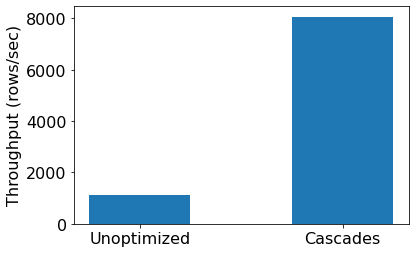

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars
num_rows = len(test_X)

bars = axes.bar(x, [num_rows / unopt_time_elapsed, num_rows / cascades_time_elapsed], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.show()